In [ ]:
import datetime as dt

In [16]:

import numpy as np
import pandas as pd
import scipy.stats as stats

import pyomo.environ as pyo

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [3]:
import yfinance as yf

### Solver

In [ ]:
solver = 'appsi_highs'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

## Data

### Download Data

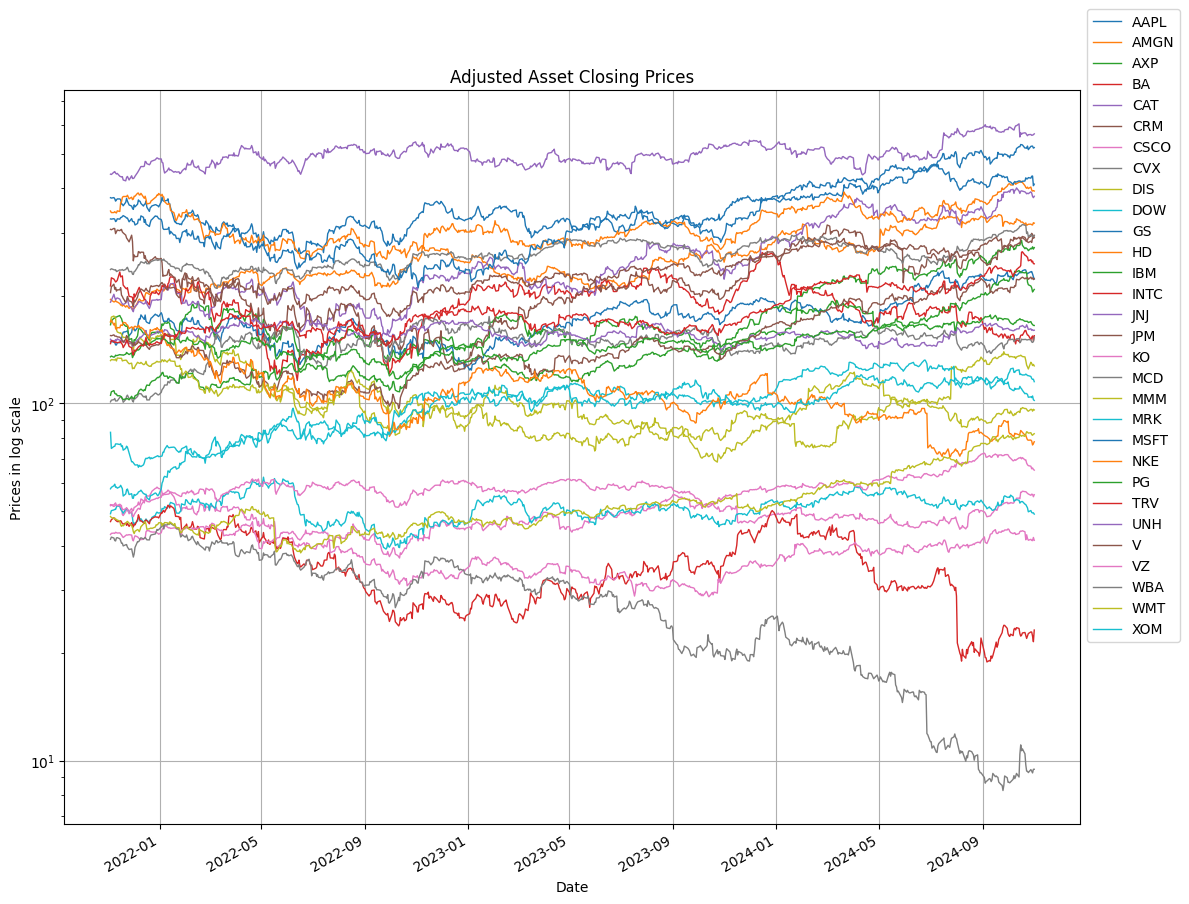

In [8]:
tickers = [
    "AXP",
    "AAPL",
    "AMGN",
    "BA",
    "CAT",
    "CRM",
    "CSCO",
    "CVX",
    "DIS",
    "DOW",
    "GS",
    "HD",
    "IBM",
    "INTC",
    "JNJ",
    "JPM",
    "KO",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "V",
    "VZ",
    "WBA",
    "WMT",
    "XOM",
]

n_years = 3.0
end_date = dt.date.today()
start_date = end_date - dt.timedelta(round(n_years * 365))

assets = yf.download(tickers, start=start_date, end=end_date, progress=False)[
    "Adj Close"
].bfill().ffill()

fig, ax = plt.subplots(figsize=(12, 9))
assets.plot(ax=ax, logy=True, grid=True, lw=1, title="Adjusted Asset Closing Prices")
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Prices in log scale")
plt.tight_layout()
plt.show()

#### Scaled Asset Prices

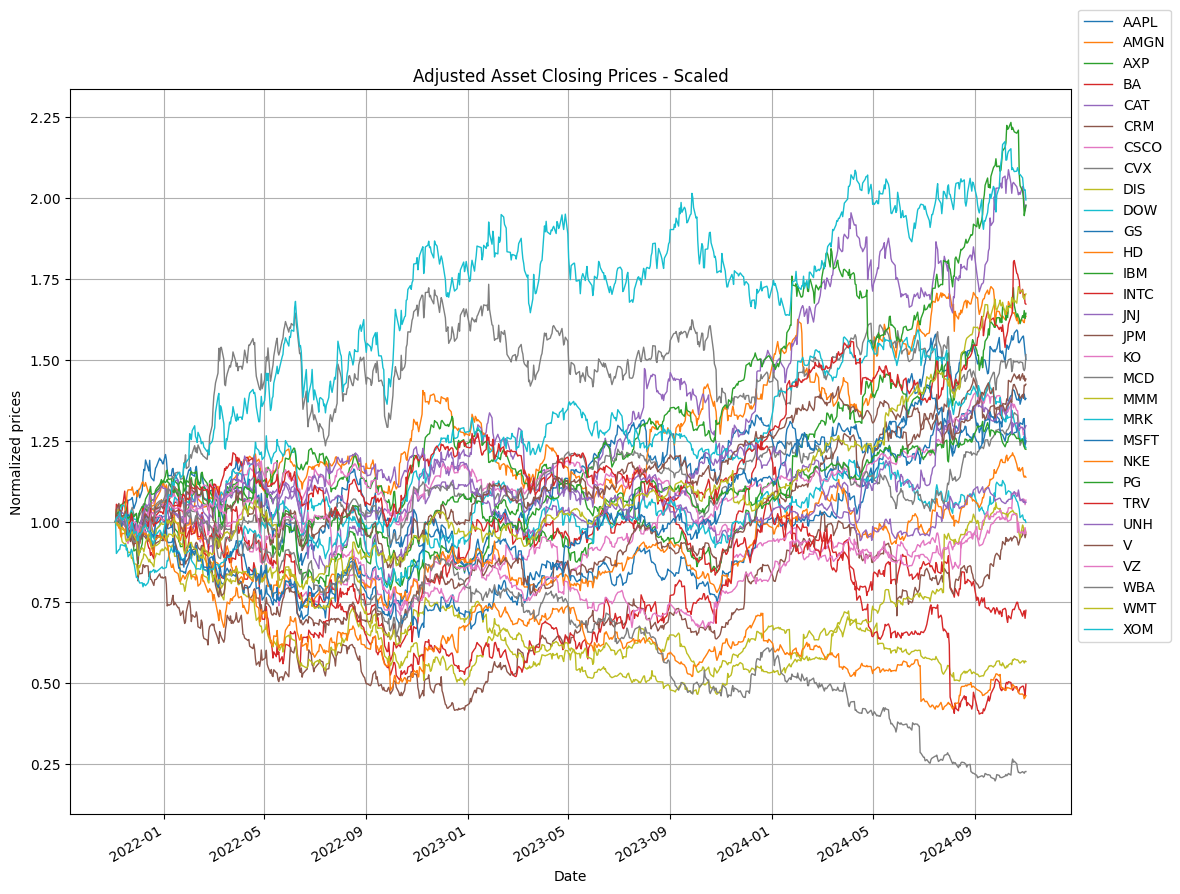

In [10]:
assets_scaled = assets.div(assets.iloc[0])

fig, ax = plt.subplots(figsize=(12, 9))
assets_scaled.plot(
    ax=ax, grid=True, lw=1, title="Adjusted Asset Closing Prices - Scaled"
)
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Normalized prices")
plt.rcParams["font.size"] = 13
plt.tight_layout()
plt.show()

#### Daily Returns

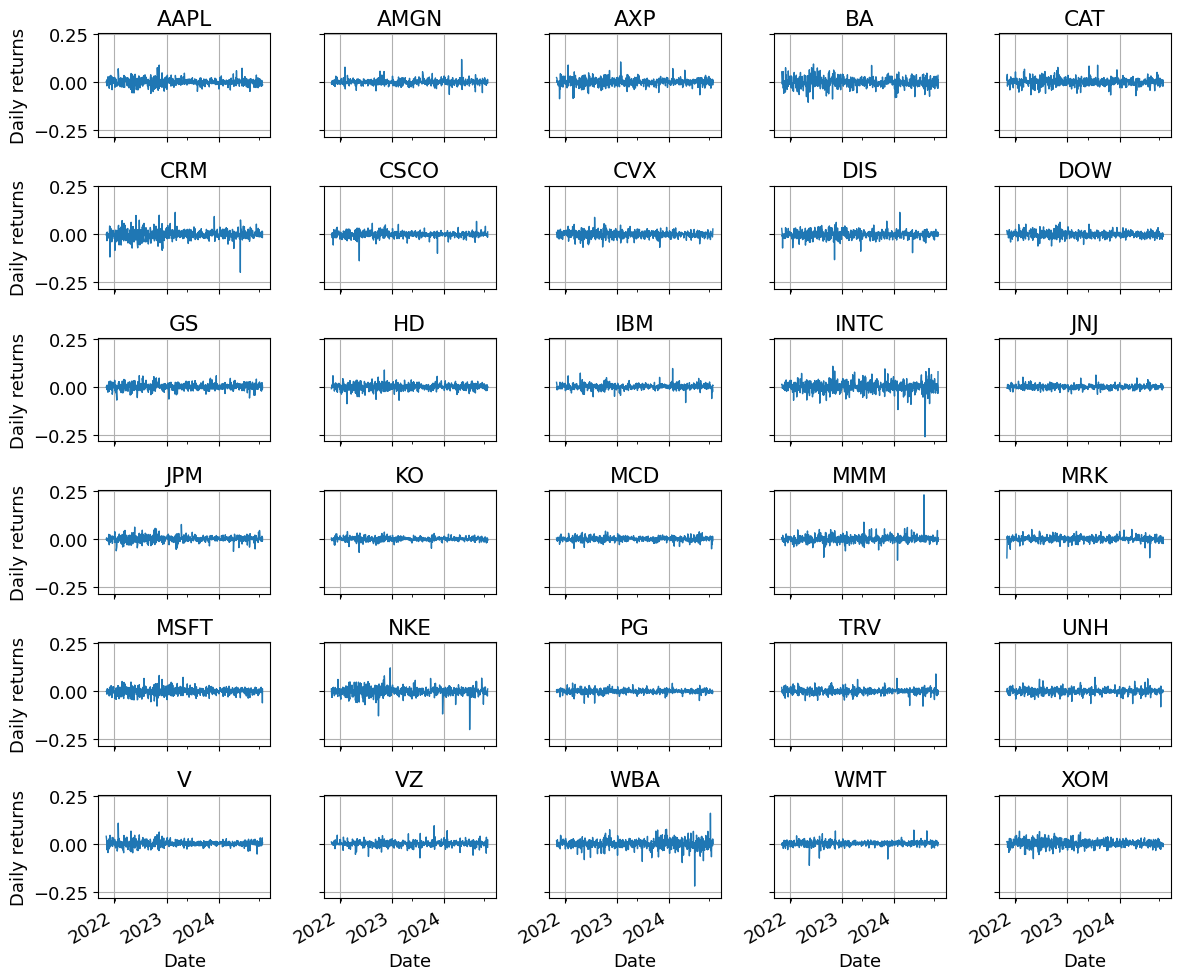

In [11]:
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)

for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
    a.xaxis.set_major_locator(mdates.YearLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    a.set_ylabel("Daily returns")

plt.tight_layout()
plt.show()

#### Mean Absolute Deviation

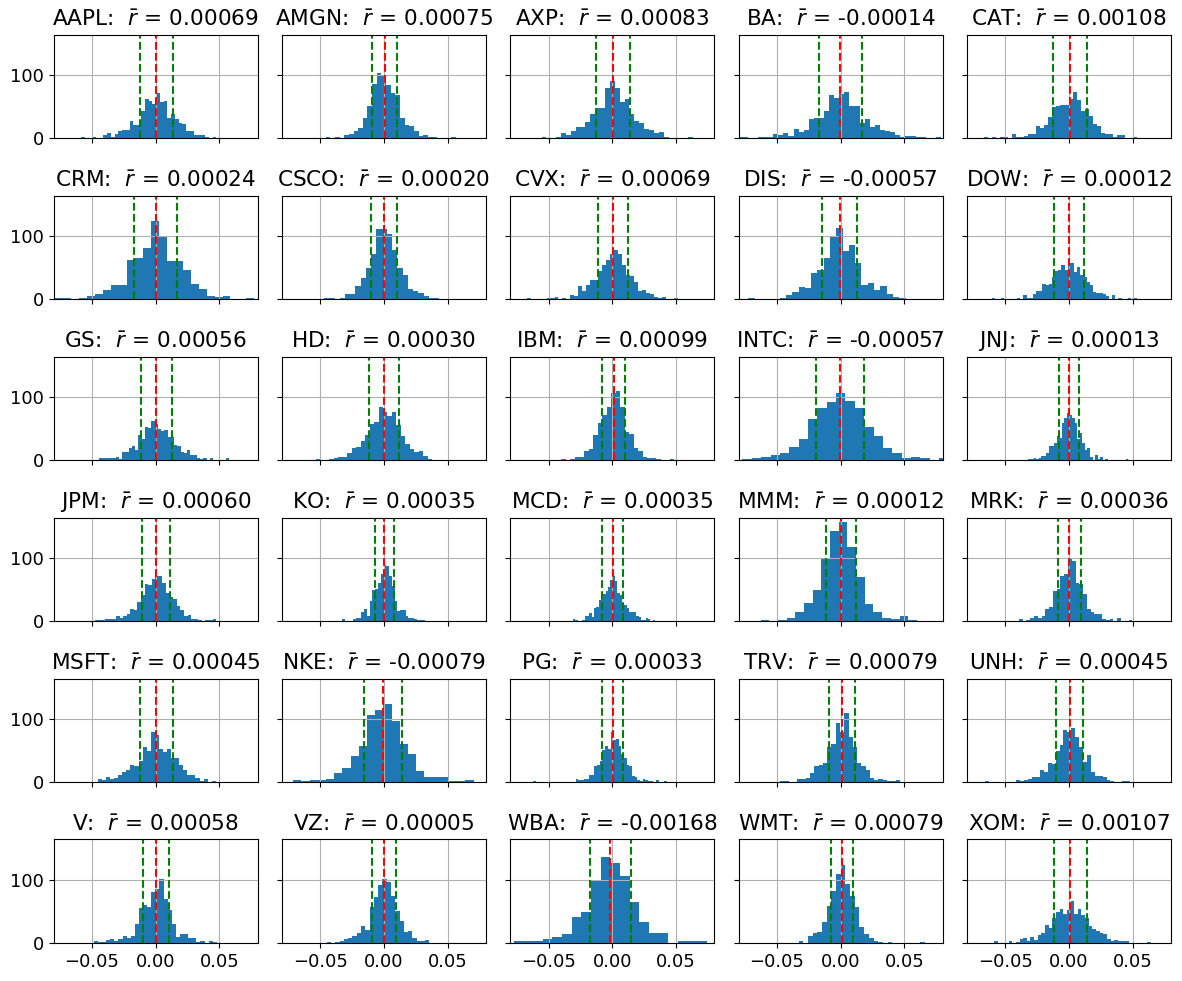

In [12]:
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    a.set_title(f"{s}:  $\\bar r$ = {mean_return[s]:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return[s], color="r", linestyle="--")
    a.axvline(mean_return[s] + mean_absolute_deviation[s], color="g", linestyle="--")
    a.axvline(mean_return[s] - mean_absolute_deviation[s], color="g", linestyle="--")

plt.tight_layout()
plt.show()

#### Risk Return

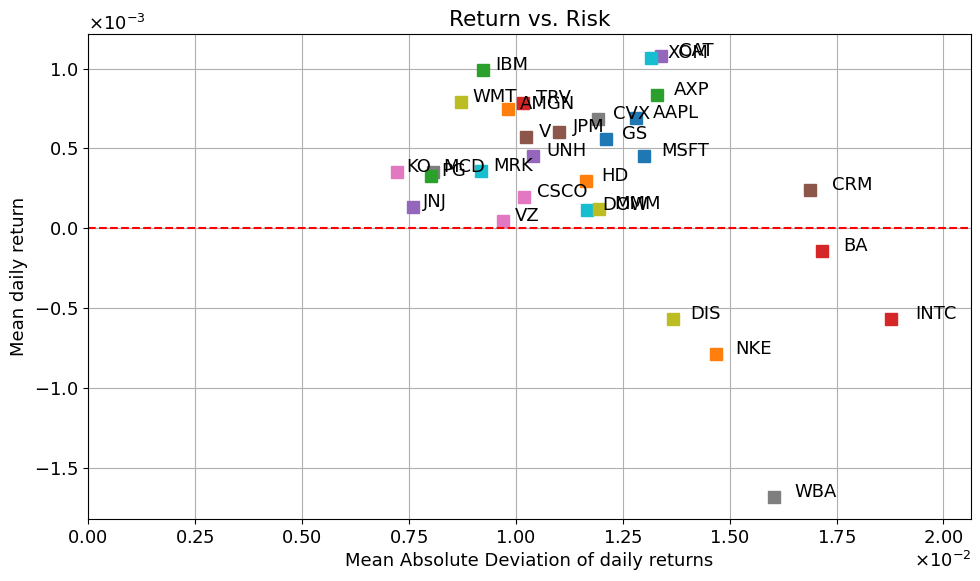

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = mpl.ticker.ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = mpl.ticker.ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * mean_absolute_deviation.max())
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation of daily returns")
ax.set_ylabel("Mean daily return")
ax.grid(True)
plt.tight_layout()
plt.show()